In [ ]:
# TODO: Address outliers in the household survey data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
import json
import ptitprince as pt
import pickle as pkl
# import contextily as ctx
from analysis import *
from ema_workbench import load_results

## Input

What kind of verification checks are we going to do?

In [3]:
household_survey = pd.read_csv('../data/processed/household_survey/Saint Lucia/Saint Lucia.csv')

The most populated district is Castries. The second place is hold by Gros Islet. The third place is hold by Vieux Fort. The least populated district is Laborie.

In [10]:
total_population = round(household_survey['popwgt'].sum())
district_population = household_survey.groupby('district')['popwgt'].sum()
print('Total population = ' + str('{:,}'.format(total_population)))
for district in household_survey['district'].unique():
    print(district + ' population = ' + str('{:,}'.format(round(district_population[district]))))

# Check whether district population is equal to the total population
assert total_population == round(district_population.sum())

Total population = 172,638
Micoud population = 17,436
Vieuxfort population = 15,229
Castries population = 70,959
Gros Islet population = 27,467
Laborie population = 6,828
Dennery population = 11,591
Choiseul population = 5,476
Soufriere population = 8,985
AnseLaRayeCanaries population = 8,667


It seems that the predominant household size is 4 people with 23%, followed by 2 people household size with around 19%.

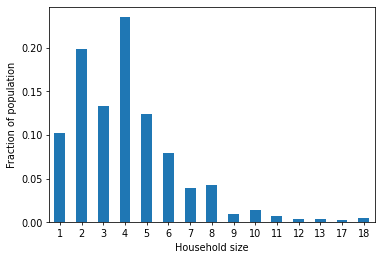

In [58]:
household_survey['hhsize_ae'] = household_survey['hhsize_ae'].astype(int)
(household_survey.groupby('hhsize_ae')['popwgt'].sum() / total_population).plot.bar(rot=0)
plt.xlabel('Household size')
plt.ylabel('Fraction of population');

In [74]:
household_survey['aeinc'] = household_survey['aeinc'].astype(float)
for district in household_survey['district'].unique():
    print(district + ' average income = ' + str(round((household_survey.loc[household_survey['district'] == district, 'aeinc'] * household_survey.loc[household_survey['district'] == district, 'popwgt']).sum() / district_population[district])))

Micoud average income = 11347
Vieuxfort average income = 10954
Castries average income = 13573
Gros Islet average income = 16351
Laborie average income = 9072
Dennery average income = 15270
Choiseul average income = 13213
Soufriere average income = 11717
AnseLaRayeCanaries average income = 11708


In [75]:
for district in household_survey['district'].unique():
    print(district + ' average expenditure per capita = ' + str(round((household_survey.loc[household_survey['district'] == district, 'aeexp'] * household_survey.loc[household_survey['district'] == district, 'popwgt']).sum() / district_population[district])))

Micoud average expenditure per capita = 14463
Vieuxfort average expenditure per capita = 12406
Castries average expenditure per capita = 13448
Gros Islet average expenditure per capita = 17596
Laborie average expenditure per capita = 11136
Dennery average expenditure per capita = 11268
Choiseul average expenditure per capita = 13438
Soufriere average expenditure per capita = 19126
AnseLaRayeCanaries average expenditure per capita = 11214


In [34]:
print(household_survey[['aeexp', 'district']].groupby('district').describe().round().iloc[:,1:].to_string(formatters={'aeexp': '{:,.0f}'.format}))

                      aeexp                                                     
                       mean      std     min     25%      50%      75%       max
district                                                                        
AnseLaRayeCanaries  14057.0  16680.0  1290.0  5466.0   8805.0  17651.0  149411.0
Castries            16205.0  15904.0     0.0  7805.0  12315.0  18787.0  240996.0
Choiseul            16339.0  13626.0  1564.0  7535.0  11880.0  19625.0   80225.0
Dennery             13644.0  17063.0  1935.0  5765.0   9493.0  15705.0  159626.0
Gros Islet          20781.0  20057.0  3832.0  8891.0  15114.0  24977.0  191948.0
Laborie             14296.0  10787.0  1632.0  7470.0  10775.0  18568.0   63126.0
Micoud              19215.0  25879.0  1063.0  7182.0  10873.0  20101.0  199949.0
Soufriere           22211.0  58157.0  2256.0  7419.0  11891.0  18680.0  598187.0
Vieuxfort           14752.0  15029.0  1672.0  6175.0   9678.0  16642.0   99556.0


## Output

In [76]:
# Load results
results = load_results('../results/results_1.tar.gz')
outcomes = prepare_outcomes_dataframe(results)
outcomes.set_index('district', inplace=True)
experiments = results[0]

In [77]:
d = {'event_damage': 'Asset damage (physical)',
     'total_asset_stock': 'Total asset stock (physical)',
     'total_asset_in_survey': 'Total asset stock (survey)',
     'total_asset_loss': 'Total asset loss (model)',
     'total_consumption_loss': 'Total consumption loss (model)',
     'r' : 'Socio-economic resilience (model)'}

In [78]:
df = outcomes.copy()
df = df[list(d.keys())].round()
df.columns = list(d.values())
df.index.name = 'District'
# Print df with comma separator for thousands with 2 decimals
df.style.format("{:,.2f}")

,Asset damage (physical),Total asset stock (physical),Total asset stock (survey),Total asset loss (model),Total consumption loss (model),Socio-economic resilience (model)
District,,,,,,
AnseLaRayeCanaries,"1,282,936.18","47,442,177.05","334,331,195.84","1,343,831.53","2,377,455.88",0.54
Castries,"31,062,668.40","1,587,405,663.34","3,435,721,049.12","58,642,048.53","86,109,421.81",0.36
Choiseul,"1,111,847.84","54,354,802.37","377,890,219.98","1,618,150.81","2,362,625.39",0.47
Dennery,"2,667,414.34","125,372,604.01","417,528,403.13","5,684,835.79","9,711,382.60",0.27
Gros Islet,"10,932,607.53","532,061,766.39","3,294,339,146.51","7,453,180.52","5,722,247.71",1.91
Laborie,"2,035,118.22","99,235,698.32","215,695,044.06","4,125,350.63","8,058,795.04",0.25
Micoud,"4,766,541.74","231,995,156.10","554,020,360.02","4,901,977.19","7,654,894.10",0.62
Soufriere,"1,679,254.31","82,756,712.06","535,928,432.44","8,368,873.98","7,764,331.59",0.22
Vieuxfort,"4,264,030.49","216,534,648.76","1,266,550,258.12","7,704,685.37","11,683,853.81",0.36
